In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.fftpack import dctn, idctn
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [25]:
img = io.imread('starry_night.jpg')
img = img.astype('float32') / 255 # normalize
# reduce contrast to prevent clipping in frequency domain operation
REDUCE_RATIO = 0.95
REDUCE_OFFSET = (1 - REDUCE_RATIO) / 2
img = (img * REDUCE_RATIO) + REDUCE_OFFSET

Original Image Information
Max: 0.9749999642372131
Min: 0.02500000037252903
Type: float32
Shape: (950, 1199, 3)


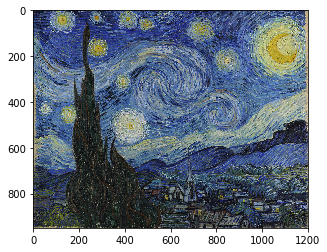

In [26]:
# original image information
print("Original Image Information")
print("Max: {}\nMin: {}".format(img.max(), img.min()))
print("Type: {}".format(img.dtype))
print("Shape: {}".format(img.shape))
plt.imshow(img)

DCT Image Information
Max: 466.95196533203125
Min: -71.90155792236328
Mean: 0.0004010933043900877
Type: float32
Shape: (950, 1199, 3)


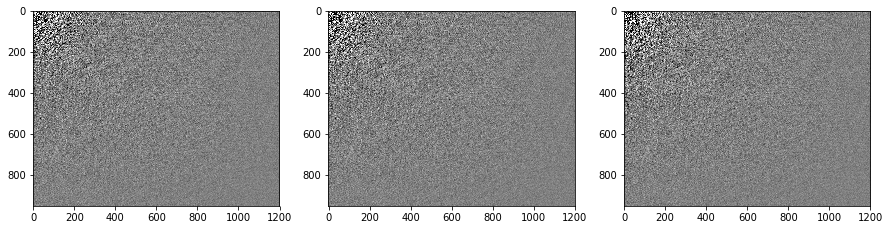

In [27]:
img_dct = dctn(img, axes=[0,1], norm='ortho')
print("DCT Image Information")
print("Max: {}\nMin: {}".format(img_dct.max(), img_dct.min()))
print("Mean: {}".format(img_dct.mean()))
print("Type: {}".format(img_dct.dtype))
print("Shape: {}".format(img_dct.shape))
# plot dct maps
NORM_BOUND = 0.5
img_dct_copy = img_dct.copy()

plt.figure(figsize=(15,4))
plt.subplot(131); plt.imshow(img_dct_copy[:,:,0], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(132); plt.imshow(img_dct_copy[:,:,1], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(133); plt.imshow(img_dct_copy[:,:,2], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')

In [28]:
MAX_FREQ = 0.8
MIN_FREQ = 0.5
SCALE    = 5e-4
THRESH   = 256*SCALE

def encode(imdct, msg):
    cnt = 0
    h, w, c = imdct.shape
    for i in range(int(MAX_FREQ*h), int(MIN_FREQ*h), -1):
        for j in range(int(MAX_FREQ*w), int(MIN_FREQ*w), -1):
            for k in range(c):
                if cnt >= len(msg):
                    imdct[i,j,k] = 0
                    return
                if abs(imdct[i,j,k]) < THRESH:
                    imdct[i,j,k] = np.sign(imdct[i,j,k])*ord(msg[cnt])*SCALE
                    cnt += 1

In [29]:
def decode(imdct):
    msg = ''
    h, w, c = imdct.shape
    for i in range(int(MAX_FREQ*h), int(MIN_FREQ*h), -1):
        for j in range(int(MAX_FREQ*w), int(MIN_FREQ*w), -1):
            for k in range(c):
                if abs(imdct[i,j,k]) < SCALE / 2:
                    return msg
                if abs(imdct[i,j,k]) < THRESH:
                    msg += chr(int(np.round(abs(imdct[i,j,k])/SCALE)))

In [34]:
# encoder / decoder unit test
message = 'z'*4000 + 'A'*10000 + '`'*8000
img_dct = dctn(img, axes=[0,1], norm='ortho')
encode(img_dct, message)
decode_msg = decode(img_dct)
assert decode_msg == message, 'Encode / Decode Failure\nDecoded: {}'.format(decode_msg)

Encoded DCT Image Information
Max: 466.95196533203125
Min: -71.90155792236328
Mean: 0.0003994980943389237
Type: float32
Shape: (950, 1199, 3)


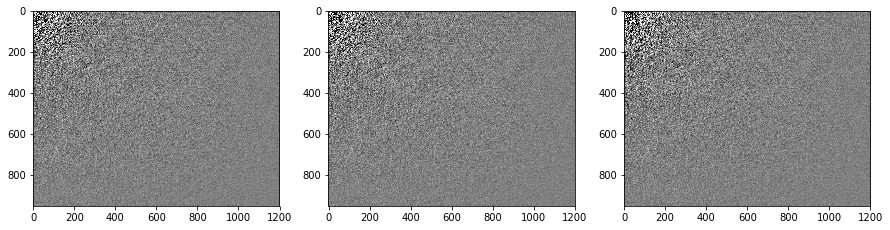

In [35]:
print("Encoded DCT Image Information")
print("Max: {}\nMin: {}".format(img_dct.max(), img_dct.min()))
print("Mean: {}".format(img_dct.mean()))
print("Type: {}".format(img_dct.dtype))
print("Shape: {}".format(img_dct.shape))
# plot dct maps
NORM_BOUND = 0.5
img_dct_copy = img_dct.copy()

plt.figure(figsize=(15,4))
plt.subplot(131); plt.imshow(img_dct_copy[:,:,0], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(132); plt.imshow(img_dct_copy[:,:,1], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(133); plt.imshow(img_dct_copy[:,:,2], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')

Recovered Image Information
Max: 0.9840519428253174
Min: 0.01306682825088501
Type: float32
Shape: (950, 1199, 3)


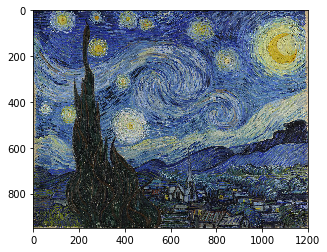

In [36]:
img_recov = idctn(img_dct, axes=[0,1], norm='ortho')
print("Recovered Image Information")
print("Max: {}\nMin: {}".format(img_recov.max(), img_recov.min()))
print("Type: {}".format(img_recov.dtype))
print("Shape: {}".format(img_recov.shape))
plt.imshow(img_recov)

In [37]:
# quantization test
QUANT_SCALE = 65535.
img_quantized = (img_recov * QUANT_SCALE).astype('uint16')
img_quant_dct = dctn(img_quantized/QUANT_SCALE, axes=[0,1], norm='ortho')
assert decode(img_quant_dct) == message, 'Reconstruct failed due to precision error'

In [38]:
# save image to disk
io.imsave('starry_encoded.tiff', img_quantized)

In [39]:
# recover from disk
img_read = io.imread('starry_encoded.tiff')
img_read_dct = dctn(img_read/QUANT_SCALE, axes=[0,1], norm='ortho')
decode(img_read_dct) == message

True

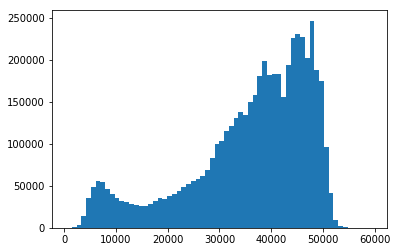

In [22]:
_ = plt.hist(img_read.flatten(), bins=64)

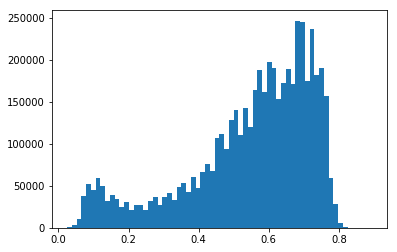

In [24]:
_ = plt.hist(img.flatten(), bins=64)